# Set up notebook environment
## NOTE: Use qiime2-2021.11 kernel

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import re
%matplotlib inline
from qiime2.plugins import feature_table
from qiime2 import Artifact
from qiime2 import Metadata
import biom
from biom import load_table
from qiime2.plugins import diversity
from scipy.stats import ttest_ind


# Assign taxonomy to reads using synthetic plasmid taxonomy file

## Unzip demux QZA's to obtain R1 files for vsearch
### NOTE: After unzipping each file, the folder was renamed to match the file name

In [ ]:
cd /projects/dna_extraction_12201/round_02_six_kit_comparison/data/16S/03_demux/

unzip dna_og_16S_plates1_6_8redos_demux.qza
unzip dna_og_16S_plates1_6_excluding_8redos_demux.qza
unzip dna_og_16S_plates7_12_demux.qza
unzip dna_rerun_16S_hbm_seqs_demux.qza
unzip dna_rerun_16S_lbm_seqs_demux.qza


In [ ]:
cd /projects/dna_extraction_12201/round_02_six_kit_comparison/data/16S/03_demux/

mv dna_og_16S_plates1_6_8redos_demux/data/*R1* /projects/dna_extraction_12201/round_02_six_kit_comparison/data/16S/14_well_to_well_contamination/01_demux_R1/
mv dna_og_16S_plates1_6_excluding_8redos_demux/data/*R1* /projects/dna_extraction_12201/round_02_six_kit_comparison/data/16S/14_well_to_well_contamination/01_demux_R1/
mv dna_og_16S_plates7_12_demux/data/*R1* /projects/dna_extraction_12201/round_02_six_kit_comparison/data/16S/14_well_to_well_contamination/01_demux_R1/
mv dna_rerun_16S_hbm_seqs_demux/data/*R1* /projects/dna_extraction_12201/round_02_six_kit_comparison/data/16S/14_well_to_well_contamination/01_demux_R1/
mv dna_rerun_16S_lbm_seqs_demux/data/*R1* /projects/dna_extraction_12201/round_02_six_kit_comparison/data/16S/14_well_to_well_contamination/01_demux_R1/


In [ ]:
#!/bin/bash
#PBS -V
#PBS -l nodes=1:ppn=16
#PBS -l walltime=12:00:00
#PBS -l mem=128gb
#PBS -M justinparkshaffer@gmail.com
#PBS -m abe

source activate qiime2-2021.11

# Import raw, demuxed sequences
qiime tools import \
  --type 'SampleData[SequencesWithQuality]' \
  --input-path /projects/dna_extraction_12201/round_02_six_kit_comparison/data/16S/14_well_to_well_contamination/01_demux_R1/ \
  --input-format CasavaOneEightSingleLanePerSampleDirFmt \
  --output-path /projects/dna_extraction_12201/round_02_six_kit_comparison/data/16S/14_well_to_well_contamination/02_vsearch/dna_all_16s_seqs_with_quality.qza

# Remove adapters (most basic QC)
qiime cutadapt trim-single \
  --i-demultiplexed-sequences /projects/dna_extraction_12201/round_02_six_kit_comparison/data/16S/14_well_to_well_contamination/02_vsearch/dna_all_16s_seqs_with_quality.qza \
  --o-trimmed-sequences /projects/dna_extraction_12201/round_02_six_kit_comparison/data/16S/14_well_to_well_contamination/02_vsearch/dna_all_16s_seqs_with_quality_trimmed.qza

# Create a table
qiime vsearch dereplicate-sequences \
  --i-sequences /projects/dna_extraction_12201/round_02_six_kit_comparison/data/16S/14_well_to_well_contamination/02_vsearch/dna_all_16s_seqs_with_quality_trimmed.qza \
  --o-dereplicated-table /projects/dna_extraction_12201/round_02_six_kit_comparison/data/16S/14_well_to_well_contamination/02_vsearch/dna_all_16s_vsearch_biom.qza \
  --o-dereplicated-sequences /projects/dna_extraction_12201/round_02_six_kit_comparison/data/16S/14_well_to_well_contamination/02_vsearch/dna_all_16s_vsearch_seqs.qza

qiime feature-table summarize \
  --i-table /projects/dna_extraction_12201/round_02_six_kit_comparison/data/16S/14_well_to_well_contamination/02_vsearch/dna_all_16s_vsearch_biom.qza \
  --o-visualization /projects/dna_extraction_12201/round_02_six_kit_comparison/data/16S/14_well_to_well_contamination/02_vsearch/dna_all_16s_vsearch_biom.qzv

# There are 1920 samples and 5446117 features


# Assign taxonomy using synthetic plasmid taxonomy file

In [ ]:
#!/bin/bash
#PBS -V
#PBS -l nodes=1:ppn=16
#PBS -l walltime=6:00:00
#PBS -l mem=128gb
#PBS -M justinparkshaffer@gmail.com
#PBS -m abe

source activate qiime2-2021.11

# Assign taxonomy
qiime feature-classifier classify-consensus-vsearch \
  --i-query /projects/dna_extraction_12201/round_02_six_kit_comparison/data/16S/14_well_to_well_contamination/02_vsearch/dna_all_16s_vsearch_seqs.qza \
  --i-reference-reads /projects/dna_extraction_12201/round_03_MagMAX_comparison/16S/snyth_16Splas_seqs.qza \
  --i-reference-taxonomy /projects/dna_extraction_12201/round_03_MagMAX_comparison/16S/synth_16Splas_taxonomy.qza \
  --o-classification /projects/dna_extraction_12201/round_02_six_kit_comparison/data/16S/14_well_to_well_contamination/03_taxonomy/dna_all_16S_deblur_seqs_taxonomy_synthetic_plasmids.qza

# Collapse taxonomy to level 1
qiime taxa collapse \
  --i-table /projects/dna_extraction_12201/round_02_six_kit_comparison/data/16S/14_well_to_well_contamination/02_vsearch/dna_all_16s_vsearch_biom.qza \
  --i-taxonomy /projects/dna_extraction_12201/round_02_six_kit_comparison/data/16S/14_well_to_well_contamination/03_taxonomy/dna_all_16S_deblur_seqs_taxonomy_synthetic_plasmids.qza \
  --p-level 1 \
  --o-collapsed-table /projects/dna_extraction_12201/round_02_six_kit_comparison/data/16S/14_well_to_well_contamination/03_taxonomy/dna_all_16S_deblur_biom_taxa_collapse_synthetic_plasmids.qza

qiime feature-table summarize \
  --i-table /projects/dna_extraction_12201/round_02_six_kit_comparison/data/16S/14_well_to_well_contamination/03_taxonomy/dna_all_16S_deblur_biom_taxa_collapse_synthetic_plasmids.qza \
  --o-visualization /projects/dna_extraction_12201/round_02_six_kit_comparison/data/16S/14_well_to_well_contamination/03_taxonomy/dna_all_16S_deblur_biom_taxa_collapse_synthetic_plasmids.qzv


# Import synthetic read counts into pandas
## NOTE: Download table, unzip, and rename file for use with biom-format

In [ ]:
biom convert \
  -i /Users/Justin/Mycelium/UCSD/00_Knight_Lab/03_Extraction_test_12201/round_02/data/16S/14_w2w/dna_all_16S_deblur_biom_taxa_collapse_synthetic_plasmids.biom \
  -o /Users/Justin/Mycelium/UCSD/00_Knight_Lab/03_Extraction_test_12201/round_02/data/16S/14_w2w/dna_all_16S_deblur_biom_taxa_collapse_synthetic_plasmids.tsv \
  --to-tsv


In [2]:
biom_collapsed = pd.read_csv('/Users/Justin/Mycelium/UCSD/00_Knight_Lab/03_Extraction_test_12201/round_02/data/16S/14_w2w/dna_all_16S_deblur_biom_taxa_collapse_synthetic_plasmids.tsv', 
                             sep = '\t',
                             index_col = 0,
                             header = 1)


In [3]:
biom_collapsed.tail()


,12201.BLANK.B4.homebrew.L,12201.BLANK.B4.magmax.L,12201.BLANK.B4.microbiome.L,12201.BLANK.B4.norgen.L,12201.BLANK.B4.nucleomag.L,12201.BLANK.B4.powersoil.L,12201.BLANK.B4.pro.L,12201.BLANK.B4.standard.L,12201.BLANK.B4.zymo.L,12201.BLANK.B4.zymoMA.L,...,12201.built.floor.B.1.zymoMA.L,12201.mc.d8.2.norgen.L,12201.mock.community.d5.norgen.H,12201.stool.mouse.K.1.homebrew.H,12201.tissue.mouse.Q.3.nucleomag.H,12201.uriM.C.1.magmax.L,12201.urine.male.A.1.zymoMA.L,12201.mock.community.d1.nucleomag.H,12201.soil.rhizosphere.I.3.nucleomag.H,12201.tissue.mouse.O.2.norgen.H
#OTU ID,,,,,,,,,,,,,,,,,,,,,
EC5002_02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EC5003_03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EC6001_06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EC5502_08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EC5005_05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
md = pd.read_csv('/Users/Justin/Mycelium/UCSD/00_Knight_Lab/03_Extraction_test_12201/round_02/sample_metadata/12201_metadata.txt',
                 sep='\t',
                 index_col=0)


In [6]:
# Sum the number of reads per synthetic plasmid
plasmid_sum = biom_collapsed
plasmid_sum = plasmid_sum.apply(pd.to_numeric)
plasmid_sum['synth_sums_across_samples'] = plasmid_sum.sum(axis=1)


In [7]:
# We expect that all plasmids should be present at some abundance - check for this.
## Make table of read counts per plasmid
plasmid_sum.synth_sums_across_samples


#OTU ID
Unassigned    37697236.0
CA5501_12       272038.0
BV5501_09       197355.0
EC5001_01       184890.0
TB5501_10       153905.0
EC5501_07        93914.0
GA5501_11        64044.0
EC5004_04        59001.0
EC5002_02        43673.0
EC5003_03        20711.0
EC6001_06        17720.0
EC5502_08        85258.0
EC5005_05        10803.0
Name: synth_sums_across_samples, dtype: float64

In [8]:
# Copy collapsed BIOM table and convert values to numeric
biom_collapsed_with_sums = biom_collapsed 
biom_collapsed_with_sums = biom_collapsed_with_sums.apply(pd.to_numeric)

# Add a row with columns sums (i.e., total synthetic plasmid reads per sample)
biom_collapsed_with_sums.loc['synth_sum'] = (biom_collapsed_with_sums.sum(axis=0) - biom_collapsed_with_sums.loc['Unassigned'])
biom_collapsed_with_sums.loc['synth_perc'] = (biom_collapsed_with_sums.loc['synth_sum'] / (biom_collapsed_with_sums.loc['Unassigned'] + biom_collapsed_with_sums.loc['synth_sum']))


In [9]:
biom_collapsed_with_sums.tail()


,12201.BLANK.B4.homebrew.L,12201.BLANK.B4.magmax.L,12201.BLANK.B4.microbiome.L,12201.BLANK.B4.norgen.L,12201.BLANK.B4.nucleomag.L,12201.BLANK.B4.powersoil.L,12201.BLANK.B4.pro.L,12201.BLANK.B4.standard.L,12201.BLANK.B4.zymo.L,12201.BLANK.B4.zymoMA.L,...,12201.built.floor.B.1.zymoMA.L,12201.mc.d8.2.norgen.L,12201.mock.community.d5.norgen.H,12201.stool.mouse.K.1.homebrew.H,12201.tissue.mouse.Q.3.nucleomag.H,12201.uriM.C.1.magmax.L,12201.urine.male.A.1.zymoMA.L,12201.mock.community.d1.nucleomag.H,12201.soil.rhizosphere.I.3.nucleomag.H,12201.tissue.mouse.O.2.norgen.H
#OTU ID,,,,,,,,,,,,,,,,,,,,,
EC6001_06,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
EC5502_08,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
EC5005_05,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
synth_sum,16.000000,0.0,0.0,3.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,7.000000,0.0,0.0,6.000000,3.000000,0.0
synth_perc,0.009834,0.0,0.0,0.004225,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.010204,0.0,0.0,0.019231,0.025424,0.0


In [10]:
biom_collapsed_with_sums_transposed = biom_collapsed_with_sums.T


In [11]:
biom_collapsed_with_sums_transposed.head()


#OTU ID,Unassigned,CA5501_12,BV5501_09,EC5001_01,TB5501_10,EC5501_07,GA5501_11,EC5004_04,EC5002_02,EC5003_03,EC6001_06,EC5502_08,EC5005_05,synth_sum,synth_perc
12201.BLANK.B4.homebrew.L,1611.0,3.0,11.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.009834
12201.BLANK.B4.magmax.L,193.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
12201.BLANK.B4.microbiome.L,629.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
12201.BLANK.B4.norgen.L,707.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.004225
12201.BLANK.B4.nucleomag.L,4996.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [12]:
md_with_biom_and_sums = pd.merge(biom_collapsed_with_sums_transposed, md, left_index=True, right_index=True)


In [13]:
md_with_biom_and_sums.head()


,Unassigned,CA5501_12,BV5501_09,EC5001_01,TB5501_10,EC5501_07,GA5501_11,EC5004_04,EC5002_02,EC5003_03,...,qc_blank_280,qc_blank_320,qc_raw_230,qc_raw_260,qc_raw_280,qc_raw_320,qiita_study_id,scientific_name,taxon_id,title
12201.BLANK.B4.homebrew.L,1611.0,3.0,11.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.042,0.04,0.057,0.049,0.046,0.043,12201,metagenome,256318,Knight sample set for testing
12201.BLANK.B4.magmax.L,193.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.042,0.04,0.047,0.042,0.04,0.038,12201,metagenome,256318,Knight sample set for testing
12201.BLANK.B4.microbiome.L,629.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,not collected,not collected,not collected,not collected,not collected,not collected,12201,metagenome,256318,Knight sample set for testing
12201.BLANK.B4.norgen.L,707.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.041,0.039,0.052,0.043,0.04,0.038,12201,metagenome,256318,Knight sample set for testing
12201.BLANK.B4.nucleomag.L,4996.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,not collected,not collected,not collected,not collected,not collected,not collected,12201,metagenome,256318,Knight sample set for testing


In [14]:
# Export metadata with BIOM table and synthetic plasmid sums
md_with_biom_and_sums.to_csv('/Users/Justin/Mycelium/UCSD/00_Knight_Lab/03_Extraction_test_12201/round_02/data/16S/14_w2w/synthetic_plasmid_results.csv', index = 1)


In [15]:
# Double-check levels for 'biomass_plate'
md_with_biom_and_sums.biomass_plate.unique()


array(['low', 'high'], dtype=object)

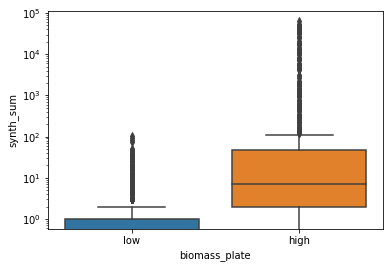

In [16]:
# We expect the synthetic plasmids to be at greater abundance in the high biomass plates more than the low biomass and COVID 
# plates (as expected since we only put into the high biomass plate) - check for this
plot_plasmids_across_plates = sns.boxplot(x = 'biomass_plate', y = 'synth_sum', data = md_with_biom_and_sums)
plot_plasmids_across_plates.set_yscale('log')


# NOTE: At this point, the summary results file generated above was manually curated to include the following columns:
row, column, plasmid_reads, plasmid_reads_log10, plasmid_reads_percent, extraction_protocol, well_type (sink vs. source)


In [ ]:
# Round 1 & 2 synthetic plasmid well locations:
## For Round 1 PowerSoil - B6 is replaced with B7 and there is no F7
A3
A11
B6
C8
D4
D10
E1
F7
G2
H5
H9
